In [2]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
import re
import os
from tqdm import tqdm, tqdm_notebook

import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup, get_scheduler


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
MAX_SEQUENCE_LENGTH = 220
SEED = 1234
EPOCHS = 1
Data_dir="./jigsaw-dataset"
WORK_DIR = "../working/"
num_to_load=1000000                         #Train size to match time limit
valid_size= 100000                          #Validation Size
TOXICITY_COLUMN = 'target'

In [30]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [18]:
# Load the training data
train = pd.read_csv(os.path.join(Data_dir, "train.csv"))

# Clean the text data
train['comment_text'] = train['comment_text'].replace({r'\s+$': '', r'^\s+': ''}, regex=True).replace(r'\n', ' ', regex=True)

# Add class labels (binary: 0 for non-toxic, 1 for toxic)
train['label'] = np.where(train['target'] >= 0.5, 1, 0)

# Retain only necessary columns
train = train[['id', 'comment_text', 'label']]

# Sample a 10% subset for demonstration
train_subset = train.sample(frac=0.5, random_state=42)

# Split into training and validation sets (80/20 split)
train_data, val_data = train_test_split(train_subset, test_size=0.2, stratify=train_subset['label'], random_state=42)

# Print data stats
print(f"Subset Training set size: {len(train_data)}")
print(f"Subset Validation set size: {len(val_data)}")

# Save the sampled training and validation sets
train_data.to_csv("train_subset.csv", index=False)
val_data.to_csv("val_subset.csv", index=False)

Subset Training set size: 721949
Subset Validation set size: 180488


In [31]:
test = pd.read_csv(os.path.join(Data_dir, "test_public_expanded.csv"))
# Clean the text data
test['comment_text'] = test['comment_text'].replace({r'\s+$': '', r'^\s+': ''}, regex=True).replace(r'\n', ' ', regex=True)

# Add class labels (binary: 0 for non-toxic, 1 for toxic)
test['label'] = np.where(test['toxicity'] >= 0.5, 1, 0)



# # Sample a 10% subset for demonstration
# train_subset = train.sample(frac=0.5, random_state=42)

# # Split into training and validation sets (80/20 split)
# train_data, val_data = train_test_split(train_subset, test_size=0.2, stratify=train_subset['label'], random_state=42)

# Print data stats
print(f"Test set size: {len(test)}")

Test set size: 97320


In [19]:
# Drop rows with null comment_text
train_data = train_data.dropna(subset=['comment_text'])
val_data = val_data.dropna(subset=['comment_text'])

# Ensure all values are strings
train_data['comment_text'] = train_data['comment_text'].astype(str)
val_data['comment_text'] = val_data['comment_text'].astype(str)

# Check data again
print("Number of null values after cleaning:")
print("Train set:", train_data['comment_text'].isnull().sum())
print("Validation set:", val_data['comment_text'].isnull().sum())



Number of null values after cleaning:
Train set: 0
Validation set: 0


In [20]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize data function
def tokenize_data(data, text_column, label_column):
    encodings = tokenizer(
        list(data[text_column]),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    labels = data[label_column].values
    return encodings, labels

# Tokenize training and validation data
train_encodings, train_labels = tokenize_data(train_data, "comment_text", "label")
val_encodings, val_labels = tokenize_data(val_data, "comment_text", "label")


In [21]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, ids, encodings, labels):
        self.ids = ids  # Store ids for reference
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Only return id for reference, not for the model
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])  # Add labels for the model
        item['id'] = self.ids[idx]  # Keep 'id' for external use only
        return item


# Create datasets
train_dataset = ToxicCommentsDataset(train_data['id'].values, train_encodings, train_labels)
val_dataset = ToxicCommentsDataset(val_data['id'].values, val_encodings, val_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [22]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
num_training_steps = len(train_loader) * 3  # Assuming 3 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Training loop
epochs = 1
model.train()

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    loop = tqdm(train_loader, desc="Training", leave=True)
    for batch in loop:
        # Move inputs to the device
        batch = {k: v.to(device) for k, v in batch.items() if k != "id"}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        # Update tqdm with the current loss
        loop.set_postfix(loss=loss.item())



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/envs/toxic/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training:   0%|          | 0/45122 [00:00<?, ?it/s]/var/tmp/ipykernel_3476/1578428153.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1/1


Training:   0%|          | 139/45122 [00:43<3:57:59,  3.15it/s, loss=0.383] 

Training: 100%|██████████| 45122/45122 [4:11:08<00:00,  2.99it/s, loss=0.0798]   


In [31]:
from tqdm import tqdm
from sklearn.metrics import classification_report

# Evaluation loop
model.eval()
val_predictions, val_true_labels, val_ids = [], [], []  # Include val_ids to track original IDs

with torch.no_grad():
    loop = tqdm(val_loader, desc="Evaluating", leave=True)
    for batch in loop:
        # Move inputs to the device, exclude 'id'
        batch_inputs = {k: v.to(device) for k, v in batch.items() if k != "id"}
        outputs = model(**batch_inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        # Collect predictions, true labels, and IDs
        val_predictions.extend(preds.cpu().numpy())
        val_true_labels.extend(batch['labels'].cpu().numpy())
        val_ids.extend(batch['id'].cpu().numpy())  # Track the original IDs

# Generate classification report
print(classification_report(val_true_labels, val_predictions, target_names=["Non-Toxic", "Toxic"]))

# Add predictions and true labels to the validation DataFrame for analysis
val_data['id'] = val_ids
val_data['true_label'] = val_true_labels
val_data['predicted_label'] = val_predictions
val_data['predicted_label'] = val_data['predicted_label'].map({0: "non-toxic", 1: "toxic"})

# Save validation results
val_data.to_csv("val_with_predictions.csv", index=False)
print("Validation predictions saved to 'val_with_predictions.csv'.")


Evaluating:   0%|          | 0/11281 [00:00<?, ?it/s]/var/tmp/ipykernel_3476/1578428153.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Evaluating: 100%|██████████| 11281/11281 [20:50<00:00,  9.02it/s]
/opt/conda/envs/toxic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/toxic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

              precision    recall  f1-score   support

   Non-Toxic       0.92      1.00      0.96    165975
       Toxic       0.00      0.00      0.00     14512

    accuracy                           0.92    180487
   macro avg       0.46      0.50      0.48    180487
weighted avg       0.85      0.92      0.88    180487

Validation predictions saved to 'val_with_predictions.csv'.


In [40]:
val_data[val_data["label"]==1]["predicted_label"]=="toxic"

605564     False
937544     False
154252     False
1635403    False
674880     False
           ...  
228771     False
391822     False
304503     False
20449      False
155752     False
Name: predicted_label, Length: 14512, dtype: bool

In [7]:
# Load original dataset
original_data = pd.read_csv(os.path.join(Data_dir, "train.csv"))

# Load validation predictions
# val_predictions = pd.read_csv("val_with_predictions.csv")

# val_predictions = val_data


In [5]:
subset_data = pd.read_csv("val_with_predictions.csv")

In [10]:
original_data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [11]:
def merge_train_val(train_df, val_df, id_col, predicted_label_col):
    """
    Merge the train and validation datasets based on the id column.
    
    Args:
        train_df (pd.DataFrame): The train dataset with subgroup information.
        val_df (pd.DataFrame): The validation dataset with predictions.
        id_col (str): The name of the id column common to both datasets.
        predicted_label_col (str): The name of the column in val_df with predicted labels.
    
    Returns:
        pd.DataFrame: A merged DataFrame containing rows from train_df with matching ids in val_df,
                      and an additional column for predicted labels.
    """
    # Merge the two datasets on the id column
    merged_df = train_df.merge(
        val_df[[id_col, predicted_label_col]],
        on=id_col,
        how="inner"  # Keep only rows from train_df that have matching ids in val_df
    )
    return merged_df

In [12]:
# Ensure both IDs are of the same type (e.g., integers or strings)
original_data["id"] = original_data["id"].astype(str)  # Update 'id' to match your column name
subset_data["id"] = subset_data["id"].astype(str)

# Filter the original dataset to keep only the rows with subset IDs
filtered_dataset = merge_train_val(original_data, subset_data, "id", "predicted_label")

In [23]:
filtered_dataset["pred"] = filtered_dataset["predicted_label"].apply(
    lambda x: 1 if x == "toxic" else 0
)
filtered_dataset["label"] = filtered_dataset["target"].apply(
    lambda x: 1 if x >= 0.5 else 0
)

In [24]:
filtered_dataset.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,predicted_label,pred,label
0,239579,0.44,This is a great story. Man. I wonder if the pe...,0.0,0.293333,0.0,0.32,0.0,0.0,0.0,...,0,0,1,0,0.04,10,75,non-toxic,0,0
1,239583,0.60,It's ridiculous that these guys are being call...,0.0,0.100000,0.0,0.60,0.1,NaN,NaN,...,0,0,3,0,0.00,0,10,non-toxic,0,1
2,239592,0.50,"Angry trolls, misogynists and Racists"", oh my....",0.0,0.000000,0.1,0.50,0.0,0.0,0.0,...,0,0,0,0,0.00,4,10,non-toxic,0,1
3,239597,0.00,She would be a major improvement for city coun...,0.0,0.000000,0.0,0.00,0.0,NaN,NaN,...,0,0,2,0,0.00,0,4,non-toxic,0,0
4,239606,0.00,Why bother writing a review if it's going to b...,0.0,0.000000,0.0,0.00,0.0,NaN,NaN,...,0,0,1,0,0.00,0,4,non-toxic,0,0


In [25]:
filtered_dataset.to_csv("merged_train_val.csv", index=False)

In [15]:
# Define subgroup columns
subgroups = [
    "asian", "atheist", "bisexual", "black", "buddhist", "christian",
    "female", "heterosexual", "hindu", "homosexual_gay_or_lesbian",
    "intellectual_or_learning_disability", "jewish", "latino", "male",
    "muslim", "other_disability", "other_gender", "other_race_or_ethnicity",
    "other_religion", "other_sexual_orientation", "physical_disability",
    "psychiatric_or_mental_illness", "transgender", "white"
]


In [19]:
filtered_dataset.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.0,This is such an urgent design problem; kudos t...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
7,59863,0.0,FFFFUUUUUUUUUUUUUUU,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
13,239583,0.6,It's ridiculous that these guys are being call...,0.0,0.1,0.0,0.6,0.1,NaN,NaN,...,26670,approved,0,0,0,3,0,0.0,0,10
17,239590,0.0,Awesome! I love Civil Comments!,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,26795,approved,0,0,0,3,0,0.0,0,4


In [21]:
filtered_dataset["label"] = np.where(filtered_dataset['target'] >= 0.5, 1, 0)
filtered_dataset.head()

/var/tmp/ipykernel_88804/289975183.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset["label"] = np.where(filtered_dataset['target'] >= 0.5, 1, 0)


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,label
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,0
2,59852,0.0,This is such an urgent design problem; kudos t...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,0
7,59863,0.0,FFFFUUUUUUUUUUUUUUU,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,0
13,239583,0.6,It's ridiculous that these guys are being call...,0.0,0.1,0.0,0.6,0.1,NaN,NaN,...,approved,0,0,0,3,0,0.0,0,10,1
17,239590,0.0,Awesome! I love Civil Comments!,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,3,0,0.0,0,4,0


In [23]:
# Assuming the label column is named 'label', update if it's named differently
label_column = 'label'

# Count the occurrences of each label
label_counts = filtered_dataset[label_column].value_counts()

# Calculate percentages
label_percentages = (label_counts / len(filtered_dataset)) * 100

# Print the results
print("Label Distribution:")
print(label_counts)
print("\nLabel Percentages:")
print(label_percentages)

Label Distribution:
label
0    22671
1     1895
Name: count, dtype: int64

Label Percentages:
label
0    92.286086
1     7.713914
Name: count, dtype: float64


In [26]:
# Count subgroup sizes in the subset
thresholded_data = (filtered_dataset[subgroups] > 0.3).astype(int)

# Count subgroup sizes in the subset
subgroup_sizes = thresholded_data.sum()

# Calculate percentages if needed
total_subset_size = len(subset_data)
subgroup_percentages = (subgroup_sizes / total_subset_size) * 100

# Display results
print("Subgroup Sizes:")
print(subgroup_sizes)

Subgroup Sizes:
asian                                   23
atheist                                 19
bisexual                                 8
black                                  219
buddhist                                 2
christian                              236
female                                 657
heterosexual                            16
hindu                                    6
homosexual_gay_or_lesbian              147
intellectual_or_learning_disability      3
jewish                                  57
latino                                  41
male                                   534
muslim                                 148
other_disability                         1
other_gender                             0
other_race_or_ethnicity                 13
other_religion                           6
other_sexual_orientation                 0
physical_disability                      2
psychiatric_or_mental_illness          111
transgender                           

In [12]:
# Initialize dictionary to store results
subgroup_accuracies = {}

# Calculate accuracy for each subgroup
for subgroup in subgroups:
    # Filter rows where the subgroup column is 1 (indicating membership in the subgroup)
    subgroup_data = merged_data[merged_data[subgroup] == 1]
    
    if not subgroup_data.empty:
        # Calculate accuracy: (correct predictions / total predictions for the subgroup)
        correct_predictions = (subgroup_data['label'] == subgroup_data['predicted_label']).sum()
        total_predictions = len(subgroup_data)
        accuracy = correct_predictions / total_predictions
        subgroup_accuracies[subgroup] = {
            "accuracy": accuracy,
            "support": total_predictions
        }
    else:
        # Handle cases where there are no members in the subgroup
        subgroup_accuracies[subgroup] = {
            "accuracy": None,
            "support": 0
        }

# Convert results to a DataFrame for better visualization
subgroup_accuracies_df = pd.DataFrame.from_dict(subgroup_accuracies, orient="index")
subgroup_accuracies_df.reset_index(inplace=True)
subgroup_accuracies_df.columns = ["Subgroup", "Accuracy", "Support"]

# Sort the DataFrame by accuracy
subgroup_accuracies_df = subgroup_accuracies_df.sort_values(by="Accuracy", ascending=False)

# Display the results
print(subgroup_accuracies_df)

# Save the results to a CSV file
subgroup_accuracies_df.to_csv("subgroup_accuracies.csv", index=False)
print("Subgroup accuracies saved to 'subgroup_accuracies.csv'.")

                               Subgroup Accuracy  Support
0                                 asian     None        0
1                               atheist     None        0
2                              bisexual     None        0
3                                 black     None        0
4                              buddhist     None        0
5                             christian     None        0
6                                female     None        0
7                          heterosexual     None        0
8                                 hindu     None        0
9             homosexual_gay_or_lesbian     None        0
10  intellectual_or_learning_disability     None        0
11                               jewish     None        0
12                               latino     None        0
13                                 male     None        0
14                               muslim     None        0
15                     other_disability     None        0
16            

In [45]:
# Check the unique values of true_label and predicted_label
print("Unique values in true_label:", merged_data['true_label'].unique())
print("Unique values in predicted_label:", merged_data['predicted_label'].unique())

Unique values in true_label: [0 1]
Unique values in predicted_label: ['non-toxic']


In [46]:
# Ensure labels are numeric
merged_data['true_label'] = merged_data['true_label'].map({"non-toxic": 0, "toxic": 1})
merged_data['predicted_label'] = merged_data['predicted_label'].map({"non-toxic": 0, "toxic": 1})

In [47]:
# Check the counts of members in each subgroup
subgroup_counts = merged_data[subgroups].sum()
print(subgroup_counts)


asian                                   463.736361
atheist                                 111.046426
bisexual                                 67.114403
black                                  1379.098045
buddhist                                 61.417463
christian                              3856.761404
female                                 5144.579718
heterosexual                            133.359952
hindu                                    61.331786
homosexual_gay_or_lesbian              1098.847852
intellectual_or_learning_disability      43.222304
jewish                                  707.944850
latino                                  253.604173
male                                   4412.883640
muslim                                 1975.144655
other_disability                         47.924642
other_gender                             36.447909
other_race_or_ethnicity                 330.702912
other_religion                          284.409976
other_sexual_orientation       

In [48]:
# Debug accuracy for the 'asian' subgroup
asian_data = merged_data[merged_data['asian'] == 1]
print("Number of samples in 'asian' subgroup:", len(asian_data))
print("Correctly predicted samples:", (asian_data['true_label'] == asian_data['predicted_label']).sum())


Number of samples in 'asian' subgroup: 129
Correctly predicted samples: 0


In [49]:
# Recalculate subgroup accuracies
subgroup_accuracies = {}

for subgroup in subgroups:
    subgroup_data = merged_data[merged_data[subgroup] == 1]
    if not subgroup_data.empty:
        correct_predictions = (subgroup_data['label'] == subgroup_data['predicted_label']).sum()
        total_predictions = len(subgroup_data)
        accuracy = correct_predictions / total_predictions
        subgroup_accuracies[subgroup] = {
            "accuracy": accuracy,
            "support": total_predictions
        }
    else:
        subgroup_accuracies[subgroup] = {
            "accuracy": None,
            "support": 0
        }

# Convert to DataFrame
subgroup_accuracies_df = pd.DataFrame.from_dict(subgroup_accuracies, orient="index")
subgroup_accuracies_df.reset_index(inplace=True)
subgroup_accuracies_df.columns = ["Subgroup", "Accuracy", "Support"]
print(subgroup_accuracies_df)


                               Subgroup  Accuracy  Support
0                                 asian  0.837209      129
1                               atheist  0.826087       46
2                              bisexual  0.750000        4
3                                 black  0.625806      775
4                              buddhist  1.000000       15
5                             christian  0.880448     1698
6                                female  0.846333     3000
7                          heterosexual  0.724138       29
8                                 hindu  0.937500       16
9             homosexual_gay_or_lesbian  0.684982      546
10  intellectual_or_learning_disability  1.000000        1
11                               jewish  0.844961      387
12                               latino  0.846154       52
13                                 male  0.831590     1912
14                               muslim  0.747784     1241
15                     other_disability       NaN       

In [50]:
# Initialize a dictionary to store subgroup FPRs
subgroup_fpr = {}

for subgroup in subgroups:
    # Filter rows where the subgroup column is 1
    subgroup_data = merged_data[merged_data[subgroup] == 1]
    
    if not subgroup_data.empty:
        # Calculate False Positives (FP) and True Negatives (TN)
        fp = ((subgroup_data['label'] == 0) & (subgroup_data['predicted_label'] == 1)).sum()
        tn = ((subgroup_data['label'] == 0) & (subgroup_data['predicted_label'] == 0)).sum()
        
        # Calculate FPR: FP / (FP + TN)
        actual_negatives = fp + tn
        fpr = fp / actual_negatives if actual_negatives > 0 else None
        subgroup_fpr[subgroup] = {
            "FPR": fpr,
            "Support": actual_negatives
        }
    else:
        # Handle cases where there are no members of the subgroup
        subgroup_fpr[subgroup] = {
            "FPR": None,
            "Support": 0
        }

# Convert to DataFrame for visualization
subgroup_fpr_df = pd.DataFrame.from_dict(subgroup_fpr, orient="index")
subgroup_fpr_df.reset_index(inplace=True)
subgroup_fpr_df.columns = ["Subgroup", "FPR", "Support"]

# Sort by FPR
subgroup_fpr_df = subgroup_fpr_df.sort_values(by="FPR", ascending=False)

# Display the results
print(subgroup_fpr_df)

# Save results to a CSV
subgroup_fpr_df.to_csv("subgroup_fpr.csv", index=False)
print("Subgroup FPR saved to 'subgroup_fpr.csv'.")


                               Subgroup  FPR  Support
0                                 asian  0.0      108
1                               atheist  0.0       38
2                              bisexual  0.0        3
3                                 black  0.0      485
4                              buddhist  0.0       15
5                             christian  0.0     1495
6                                female  0.0     2539
7                          heterosexual  0.0       21
8                                 hindu  0.0       15
9             homosexual_gay_or_lesbian  0.0      374
10  intellectual_or_learning_disability  0.0        1
11                               jewish  0.0      327
12                               latino  0.0       44
13                                 male  0.0     1590
14                               muslim  0.0      928
17              other_race_or_ethnicity  0.0        1
18                       other_religion  0.0        2
21        psychiatric_or_men

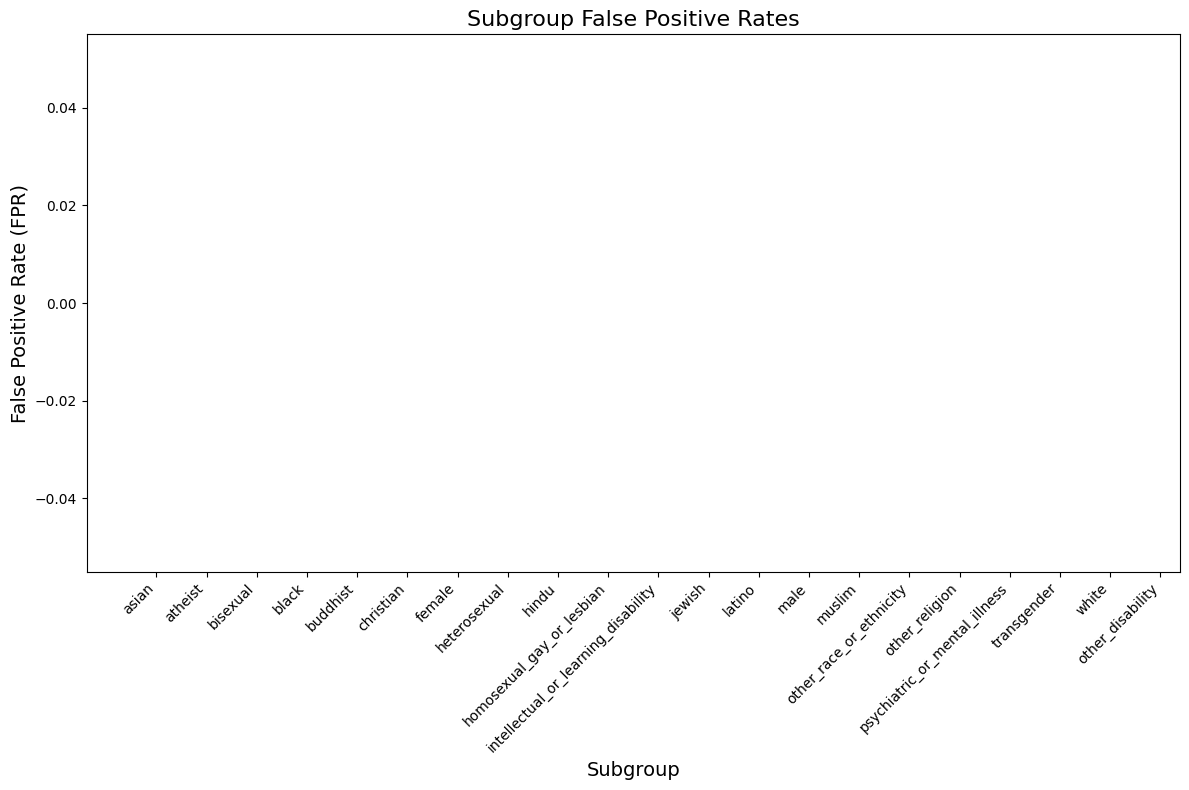

In [51]:
import matplotlib.pyplot as plt

# Plot subgroup FPRs
plt.figure(figsize=(12, 8))
plt.bar(subgroup_fpr_df['Subgroup'], subgroup_fpr_df['FPR'], color='lightcoral')
plt.xlabel('Subgroup', fontsize=14)
plt.ylabel('False Positive Rate (FPR)', fontsize=14)
plt.title('Subgroup False Positive Rates', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [52]:
# Directory to save the model
output_dir = "bert_model_checkpoint_0.5M"

# Save the model
model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to '{output_dir}'")

Model and tokenizer saved to 'bert_model_checkpoint_0.5M'


In [26]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# Load the training data
train = pd.read_csv("sliced_dataset.csv")

# Clean the text data
train['comment_text'] = train['comment_text'].replace({r'\s+$': '', r'^\s+': ''}, regex=True).replace(r'\n', ' ', regex=True)

# Add class labels (binary: 0 for non-toxic, 1 for toxic)
train['label'] = np.where(train['target'] >= 0.5, 1, 0)

# Retain only necessary columns
train = train[['id', 'comment_text', 'label']]

# Sample a 10% subset for demonstration
train_subset = train.sample(frac=0.5, random_state=42)

# Split into training and validation sets (80/20 split)
train_data, val_data = train_test_split(train_subset, test_size=0.2, stratify=train_subset['label'], random_state=42)

# Print data stats
print(f"Subset Training set size: {len(train_data)}")
print(f"Subset Validation set size: {len(val_data)}")


Subset Training set size: 9826
Subset Validation set size: 2457


In [27]:

# Save the sampled training and validation sets
train_data.to_csv("train_subset.csv", index=False)
val_data.to_csv("val_subset.csv", index=False)
test = pd.read_csv(os.path.join(Data_dir, "test_public_expanded.csv"))
# Clean the text data
test['comment_text'] = test['comment_text'].replace({r'\s+$': '', r'^\s+': ''}, regex=True).replace(r'\n', ' ', regex=True)

# Add class labels (binary: 0 for non-toxic, 1 for toxic)
test['label'] = np.where(test['toxicity'] >= 0.5, 1, 0)

# Print data stats
print(f"Test set size: {len(test)}")


Test set size: 97320


In [28]:
# Drop rows with null comment_text
train_data = train_data.dropna(subset=['comment_text'])
val_data = val_data.dropna(subset=['comment_text'])

# Ensure all values are strings
train_data['comment_text'] = train_data['comment_text'].astype(str)
val_data['comment_text'] = val_data['comment_text'].astype(str)

# Check data again
print("Number of null values after cleaning:")
print("Train set:", train_data['comment_text'].isnull().sum())
print("Validation set:", val_data['comment_text'].isnull().sum())



Number of null values after cleaning:
Train set: 0
Validation set: 0


In [29]:

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize data function
def tokenize_data(data, text_column, label_column):
    encodings = tokenizer(
        list(data[text_column]),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    labels = data[label_column].values
    return encodings, labels

# Tokenize training and validation data
train_encodings, train_labels = tokenize_data(train_data, "comment_text", "label")
val_encodings, val_labels = tokenize_data(val_data, "comment_text", "label")

class ToxicCommentsDataset(Dataset):
    def __init__(self, ids, encodings, labels):
        self.ids = ids  # Store ids for reference
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Only return id for reference, not for the model
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])  # Add labels for the model
        item['id'] = self.ids[idx]  # Keep 'id' for external use only
        return item


# Create datasets
train_dataset = ToxicCommentsDataset(train_data['id'].values, train_encodings, train_labels)
val_dataset = ToxicCommentsDataset(val_data['id'].values, val_encodings, val_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [31]:

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("CREST/outputs/Jigsaw_transformer_lr0.1_warm-20_train0.10_random0.01-start0_batchsize16_crest-batchnummul3.0-interalmul200.0_thresh-factor0.1_coreset_momentum_seed_6/model_epoch_1.1377.pt", num_labels=2)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
num_training_steps = len(train_loader) * 3  # Assuming 3 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Training loop
epochs = 10
model.train()

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    loop = tqdm(train_loader, desc="Training", leave=True)
    for batch in loop:
        # Move inputs to the device
        batch = {k: v.to(device) for k, v in batch.items() if k != "id"}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        # Update tqdm with the current loss
        loop.set_postfix(loss=loss.item())



Training:   0%|          | 0/615 [00:00<?, ?it/s]/var/tmp/ipykernel_481144/293637050.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Training:   0%|          | 1/615 [00:00<01:28,  6.90it/s, loss=0.775]

Epoch 1/10


Training:   0%|          | 1/615 [00:00<01:34,  6.50it/s, loss=0.0604]

Epoch 2/10


Training:   0%|          | 1/615 [00:00<01:35,  6.42it/s, loss=0.223]

Epoch 3/10


Training:   0%|          | 1/615 [00:00<01:33,  6.58it/s, loss=0.23]

Epoch 4/10


Training:   0%|          | 1/615 [00:00<01:35,  6.43it/s, loss=0.606]

Epoch 5/10


Training:   0%|          | 1/615 [00:00<01:31,  6.68it/s, loss=0.0771]

Epoch 6/10


Training:   0%|          | 1/615 [00:00<01:32,  6.63it/s, loss=0.0762]

Epoch 7/10


Training:   0%|          | 1/615 [00:00<01:35,  6.45it/s, loss=0.248]

Epoch 8/10


Training:   0%|          | 1/615 [00:00<01:33,  6.55it/s, loss=0.266]

Epoch 9/10


Training:   0%|          | 1/615 [00:00<01:35,  6.45it/s, loss=0.398]

Epoch 10/10


Training: 100%|██████████| 615/615 [01:39<00:00,  6.16it/s, loss=1.32]  


In [32]:
# Directory to save the model
output_dir = "bert_model_checkpoint_on_sliced_data.pt"

# Save the model
model.save_pretrained(output_dir)

In [ ]:

from tqdm import tqdm
from sklearn.metrics import classification_report

# Evaluation loop
model.eval()
val_predictions, val_true_labels, val_ids = [], [], []  # Include val_ids to track original IDs

with torch.no_grad():
    loop = tqdm(val_loader, desc="Evaluating", leave=True)
    for batch in loop:
        # Move inputs to the device, exclude 'id'
        batch_inputs = {k: v.to(device) for k, v in batch.items() if k != "id"}
        outputs = model(**batch_inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        # Collect predictions, true labels, and IDs
        val_predictions.extend(preds.cpu().numpy())
        val_true_labels.extend(batch['labels'].cpu().numpy())
        val_ids.extend(batch['id'].cpu().numpy())  # Track the original IDs

# Generate classification report
print(classification_report(val_true_labels, val_predictions, target_names=["Non-Toxic", "Toxic"]))

# Add predictions and true labels to the validation DataFrame for analysis
val_data['id'] = val_ids
val_data['true_label'] = val_true_labels
val_data['predicted_label'] = val_predictions
val_data['predicted_label'] = val_data['predicted_label'].map({0: "non-toxic", 1: "toxic"})

# Save validation results
val_data.to_csv("val_with_predictions_sliced.csv", index=False)
print("Validation predictions saved to 'val_with_predictions_sliced.csv'.")
